In [22]:
import numpy as np
from PIL import Image
from io import BytesIO
import torch

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import ProjectedGradientDescent

import cv2
import matplotlib
import matplotlib.pyplot as plt

from ultralytics import YOLO

from torchvision import datasets, transforms

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [80]:
#convert onnx to pytorch
import onnx
from onnx2pytorch import ConvertModel

onnx_model = onnx.load('/home/aya/Desktop/Kitti-ObjectDetection/best.onnx')
pytorch_model = ConvertModel(onnx_model)

#put the model in evaluation mode
pytorch_model.eval()

/home/aya/.local/lib/python3.10/site-packages/onnx2pytorch/convert/attribute.py:101: UserWarning: Pytorch's interpolate uses no coordinate_transformation_mode=asymmetric. Result might differ.
  warnings.warn(
/home/aya/.local/lib/python3.10/site-packages/onnx2pytorch/operations/resize.py:16: UserWarning: Pytorch's interpolate uses no cubic_coeff_a. Result might differ.
  warnings.warn(
/home/aya/.local/lib/python3.10/site-packages/onnx2pytorch/operations/resize.py:16: UserWarning: Pytorch's interpolate uses no nearest_mode. Result might differ.
  warnings.warn(


ConvertModel(
  (Conv_/model.0/conv/Conv_output_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Sigmoid_/model.0/act/Sigmoid_output_0): Sigmoid()
  (Mul_/model.0/act/Mul_output_0): mul()
  (Conv_/model.1/conv/Conv_output_0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Sigmoid_/model.1/act/Sigmoid_output_0): Sigmoid()
  (Mul_/model.1/act/Mul_output_0): mul()
  (Conv_/model.2/cv1/conv/Conv_output_0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (Sigmoid_/model.2/cv1/act/Sigmoid_output_0): Sigmoid()
  (Mul_/model.2/cv1/act/Mul_output_0): mul()
  (Constant_onnx::Split_140): Constant(constant=tensor([16, 16]))
  (Split_/model.2/Split_output_0): Split()
  (Conv_/model.2/m.0/cv1/conv/Conv_output_0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Sigmoid_/model.2/m.0/cv1/act/Sigmoid_output_0): Sigmoid()
  (Mul_/model.2/m.0/cv1/act/Mul_output_0): mul()
  (Conv_/model.2/m.0/cv2/conv/Conv_output_0): Conv2d(16, 16, kerne

In [83]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "'/home/aya/Desktop/Kitti-ObjectDetection/yolov8n_costum.pt'"
use_cuda=True

In [84]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network

CUDA Available:  True


In [85]:
from torchvision.transforms import Compose, RandomCrop, ToTensor

from torch_kitti.depth_completion import KittiDepthCompletionDataset
from torch_kitti.transforms import ApplyToFeatures

transform = ApplyToFeatures(
    Compose(
        [
            ToTensor(),
            RandomCrop([256, 512]),
        ]
    ),
    features=["img", "gt", "lidar"],)

# KITTI Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.Kitti('/home/aya/Kitti-ObjectDetection/KITTI-original/',
                   train=False,
                   download=False,
                   transform=transform,))

In [87]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [88]:
#test 
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [89]:
#run the attack
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(pytorch_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

TypeError: dict() argument after ** must be a mapping, not PngImageFile

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

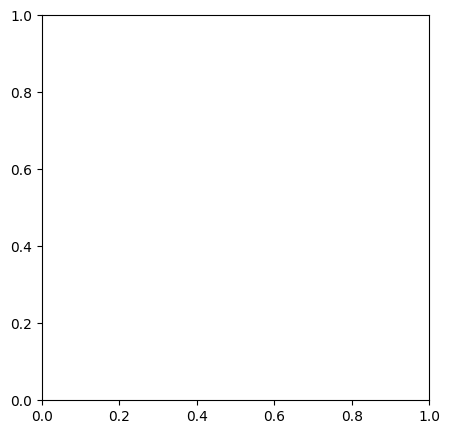

In [62]:
#plot accuracy
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()